In [23]:
from datetime import datetime, timedelta
from src.polygon_util import get_price_history

TICKER = "TSLA"

to_date = datetime.today()
from_date = to_date - timedelta(days=30)
results = get_price_history(TICKER, from_date=from_date, to_date=to_date)

try: 
  data = [r for r in results['results']]
  print([ r['c']  for r in data])
except Exception as e:
  print(f'{e}')

'results'


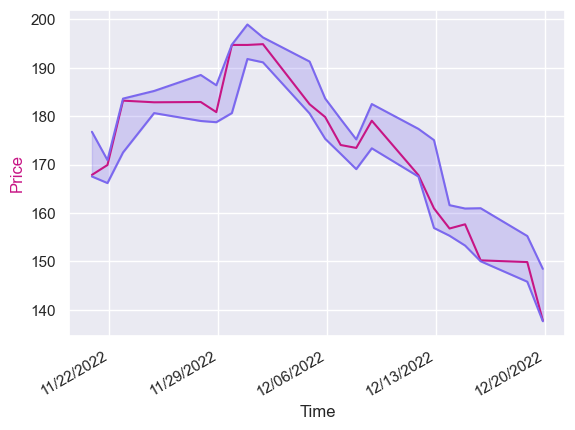

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

pf = pd.DataFrame(data)

pf['spr'] = pf['h'] - pf['l']
pf['t'] = pf['t'].apply(lambda x: datetime.fromtimestamp(x / 1000))
pf['date'] = pf['t']
pf.set_index('date', inplace=True)

fig, ax1 = plt.subplots() 
ax1.set_xlabel('Time') 
ax1.set_ylabel('Price', color = 'mediumvioletred')
ax1.plot(pf['t'], pf['c'], color='mediumvioletred')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Spread', color = 'blue') 
ax1.plot(pf['t'], pf['h'], color='mediumslateblue')
ax1.plot(pf['t'], pf['l'], color='mediumslateblue')
ax1.fill_between(
    pf['t'], pf['l'], pf['h'], where=(pf['l'] < pf['h']), 
    interpolate=True, color="mediumslateblue", alpha=0.25, 
    label="Spread"
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator()) 
plt.gcf().autofmt_xdate()
plt.show()

DatetimeIndex(['2022-11-30', '2022-12-01', '2022-12-02', '2022-12-05',
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-19'],
              dtype='datetime64[ns]', name='date', freq=None)


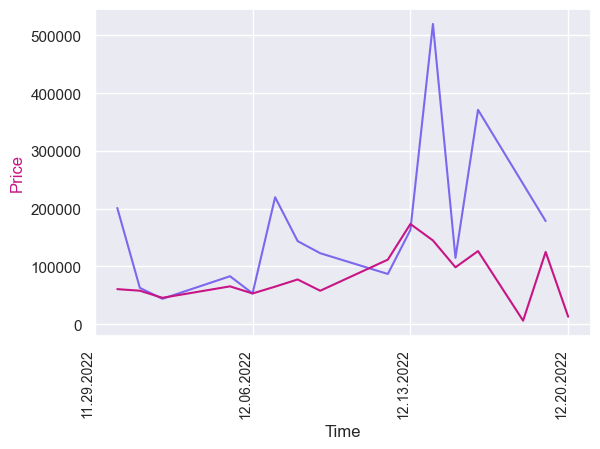

In [12]:
from numpy import NaN
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.models.aggregrates import Aggregates
from src.polygon_util import load_price_adjuster
lookback = 14
agg = Aggregates()
# calls = agg.getSet(where=f'ticker LIKE "O:{TICKER}22%C%"', offset=0, limit=11000, order='asc', order_by='ticker')
# puts = agg.getSet(where=f'ticker LIKE "O:{TICKER}22%P%"', offset=0, limit=11000, order='asc', order_by='ticker')
query = f""" 
          SELECT date, sum(volume) as v, avg(vw) as vw, avg(high - low) as spread, avg(close) as close, sum(number) 
          FROM aggregates 
          WHERE ticker LIKE %s AND date >= (CURDATE() - INTERVAL 30 DAY)
          GROUP BY date ORDER by date asc
      """
calls = agg.getResult(query, (f'O:{TICKER}2%C%',))
calls = agg.getResult(query, (f'O:{TICKER}2%P%',))


df_calls = pd.DataFrame(calls)
df_calls['date'] = df_calls['date'].apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_calls['_date'] = df_calls['date']
df_calls.set_index('date', inplace=True)
df_calls['type'] = 'call'
def adjust(x):
  # adjuster = load_price_adjuster(TICKER)

  split_1 = datetime.strptime("2022-08-24", "%Y-%m-%d")
  if x['_date'] <= split_1:
    print(f"Adj {pf.loc[x._date.date().strftime('%Y-%m-%d')]}")
    return x['close'] / 3
  return x['close']

def calc_intrinsic(x):
  try:
    return x.close - pf.loc[x._date.date().strftime('%Y-%m-%d')]['c'][0]
  except:
    return NaN

def stock_price(x):
  try:
    return x.close - pf.loc[x._date.date().strftime('%Y-%m-%d')]['c'][0]
  except:
    return NaN
    

# df_calls['close'] = df_calls.apply(lambda x: adjust(x), axis=1)
print(df_calls.index)
df_calls['intrinsic'] = df_calls.apply(calc_intrinsic, axis=1)
df_calls['stock'] = df_calls.apply(stock_price, axis=1)
df_puts = pd.DataFrame(puts)
df_puts['date'] = df_puts['date'].apply(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_puts['_date'] = df_puts['date']
df_puts.set_index('date', inplace=True)
df_puts['type'] = 'put'
df_puts['intrinsic'] = df_puts.apply(calc_intrinsic, axis=1)
df_puts['stock'] = df_puts.apply(stock_price, axis=1)
fig, ax1 = plt.subplots()


# ax2 = ax1.twinx()
# ax2.set_ylabel('Underlying', color = 'olivedrab') 
# ax2.plot(pf.index, pf['c'], color='olivedrab')
# ax2.grid(visible=False)

ax1.set_xlabel('Time') 
ax1.set_ylabel('Price', color = 'mediumvioletred')
ax1.plot(df_calls.index, df_calls['v'], color='mediumslateblue')
ax1.plot(df_puts.index, df_puts['v'], color='mediumvioletred')
ax1.tick_params(axis='x',labelsize=10,rotation=120)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator()) 
plt.gcf().autofmt_xdate(rotation=90, ha='right')
plt.show()
